In [1]:
import pandas as pd

df = pd.read_csv("nps.csv", parse_dates=["event_date"])
df.head()

,event_date,user_id,score
0,2020-01-01 19:00:51,290067447,8
1,2020-01-02 17:34:43,223014806,10
2,2020-01-02 19:11:55,187864388,10
3,2020-01-02 19:27:00,318758952,8
4,2020-01-02 21:42:19,189933311,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3326 entries, 0 to 3325
Data columns (total 3 columns):
event_date    3326 non-null datetime64[ns]
user_id       3326 non-null int64
score         3326 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 78.1 KB


In [4]:
df.describe()

,user_id,score
count,3.326000e+03,3326.000000
mean,2.709436e+08,8.542995
std,1.029014e+08,2.016276
min,6.406331e+07,0.000000
25%,1.899319e+08,8.000000
50%,2.892169e+08,9.000000
75%,3.666392e+08,10.000000
max,4.441428e+08,10.000000


In [6]:
year = df["event_date"].dt.year
month = df["event_date"].dt.month
df["yearmonth"] = 100*year + month

def categorize(score):
    """Returns NPS category"""
    if score in range(0,7):
        return "Detractor"
    elif score in (7, 8):
        return "Passive"
    elif score in (9,10):
        return "Promoter"
    return None

df["category"] = df["score"].apply(categorize)

nps = df.pivot_table(index="yearmonth", columns="category", aggfunc="size")
nps["total_responses"] = nps.sum(axis="columns")
nps["nps"] = (nps["Promoter"]-nps["Detractor"])/nps["total_responses"]
nps["nps"] = (100*nps["nps"]).astype(int)

In [7]:
nps

category,Detractor,Passive,Promoter,total_responses,nps
yearmonth,,,,,
202001,31,82,215,328,56
202002,22,90,161,273,50
202003,33,72,125,230,40
202004,36,87,178,301,47
202005,33,83,191,307,51
202006,32,80,215,327,55
202007,48,95,258,401,52
202008,40,103,256,399,54
202009,18,68,135,221,52


In [8]:
nps.max()

category
Detractor           48
Passive            103
Promoter           258
total_responses    401
nps                 56
dtype: int64

In [9]:
ax = nps.reset_index().plot(kind="line", x="yearmonth",y="nps",
                            figsize=(12,6), legend=False
                           )
ax.set_xticks(nps.index)
ax.set_xticklabels(nps.index, rotation=45)
ax.axes.get_xaxis().set_label_text("")

Text(0.5, 0, '')

In [14]:
subs = pd.read_csv("muscle_labs.csv", parse_dates=["end_date", "start_date"])
subs["churn_month"] = subs["end_date"].dt.year*100 + subs["end_date"].dt.month
monthly_churn = pd.DataFrame({"total_churned": subs.groupby("churn_month").size()})

In [15]:
years = list(range(2011,2015))
months = list(range(1,13))
yearmonths = [y*100+m for y in years for m in months]
yearmonths = yearmonths[:-1]

churn = pd.DataFrame({"yearmonth": yearmonths})

years = list(range(2011,2015))
months = list(range(1,13))
yearmonths = [y*100+m for y in years for m in months]
yearmonths = yearmonths[:-1]

churn = pd.DataFrame({"yearmonth": yearmonths})
churn = pd.merge(churn, monthly_churn, "left", left_on="yearmonth", right_index=True)
churn.fillna(0, inplace=True)
churn["total_churned"] = churn["total_churned"].astype(int)

In [17]:
churn.max()

yearmonth        201411
total_churned       159
dtype: int64

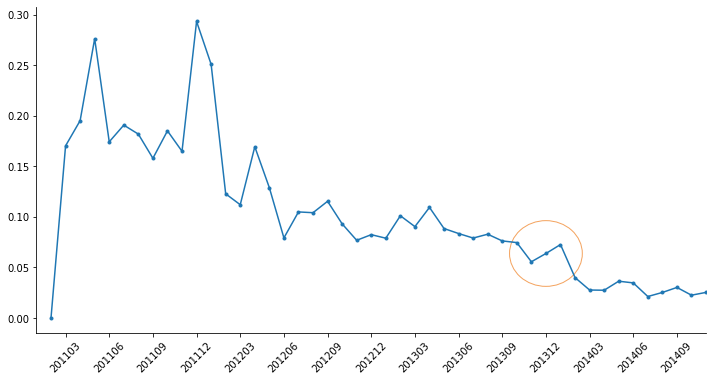

In [19]:
import datetime as dt

def get_customers(yearmonth):
    year = yearmonth//100
    month = yearmonth-year*100
    date = dt.datetime(year, month, 1)
    
    return ((subs["start_date"] < date) & (date <= subs["end_date"])).sum()

churn["total_customers"] = churn["yearmonth"].apply(get_customers)
churn["churn_rate"] = churn["total_churned"] / churn["total_customers"]
churn["yearmonth"] = churn["yearmonth"].astype(str)

arange = __import__("numpy").arange
Ellipse = __import__("matplotlib").patches.Ellipse
ax = churn.plot(x="yearmonth", y="churn_rate", figsize=(12,6), rot=45, marker=".")
start, end = ax.get_xlim()
ax.get_xticks()
ax.set_xticks(arange(2, end, 3))
ax.set_xticklabels(yearmonths[2::3])
circle = Ellipse((35, churn.loc[churn.yearmonth == "201312", "churn_rate"].iloc[0]),
                 5, 0.065, color='sandybrown', fill=False
                   )
ax.add_artist(circle)
ax.xaxis.label.set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_legend().remove()